# Youtube Observational G-Test
### Notebook based on "Trending YouTube Video Statistics"
***

<img src='https://upload.wikimedia.org/wikipedia/commons/e/e1/Logo_of_YouTube_%282015-2017%29.svg'>

# Table of Contents

* [1. Importing dataset and data preprocessing](#importing_dataset_and_data_preprocessing) <br>
 * [1.1. Importing essential libraries](#importing_essential_libraries) <br>
 * [1.2. Importing datasets](#importing_datasets) <br>
 * [1.3. Let's summarize the datasets](#lets_summarize_the_dataset) <br>
 * [1.4. Data preprocessing and feature engineering](#data_preprocessing_and_feature_engineering) <br>
   * [1.4.1. Datetime format of Trending date and Publish time](#datetime_format_of_trending_date_and_publish_time) <br>
   * [1.4.2. Assignment of the film category](#assignment_of_the_film_category) <br>
   * [1.4.3. Dislike percentage](#dislike_percentage) <br>
   * [1.4.4. Number of words with all upper case in title](#number_of_words_with_all_upper_case_in_title) <br>
   * [1.4.5. Distribution of basic parameters](#distribution_of_basic_parameters) <br>
   * [1.4.6. What about duplicates?](#what_about_duplicates) <br>
   * [1.4.7. Time to trend](#time_to_trend) <br>
<br>
* [2. Data Visualization](#data_visualization) <br>
 * [2.1. Best time to publish video](#best_time_to_publish_video) <br>
 * [2.2. It got viral](#it_got_viral) <br>
 * [2.3. Most influential creators](#most_influential_creators) <br>
 * [2.4. Variety of topics](#variety_of_topics) <br>
 * [2.5. Late bloomers](#late_bloomers) <br>
 * [2.6. No such thing as bad press, right?](#no_such_thing_as_bad_press_right) <br>
 * [2.7. Likes vs dislikes distribution!](#likes_vs_dislikes_distribution) <br>

## 1. Importing dataset and data preprocessing
<a id="importing_dataset_and_data_preprocessing"></a>

### 1.1. Importing essential libraries
<a id="importing_essential_libraries"></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# Reconstrtuction libraries
import scipy.sparse as sp
import ete3

### 1.2. Importing dataset
<a id="importing_datasets"></a>

In [6]:
us_videos = pd.read_csv('../youtube_dataset/USvideos.csv')
us_videos_categories = pd.read_json('../youtube_dataset/US_category_id.json')

### 1.3. Let's summarize the dataset
<a id="lets_summarize_the_dataset"></a>

In [4]:
us_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


### 1.4. Data preprocessing and feature engineering
<a id="data_preprocessing_and_feature_engineering"></a>

### 1.4.1. Datetime format of Trending date and Publish time
<a id="datetime_format_of_trending_date_and_publish_time"></a>

<b>NOTE:</b> We immediately see, that in the first place we have to process the raw data loaded from the file. Firstly we will transform ```trending_date``` as well as ```publish_time``` from string to datetime format. This will allow us to easily perform arithmetic operations and compare these values. ```publish_time``` column will be divided into two separate ones ```publish_date``` and ```publish_time```. I am also curious what time it is best to publish videos to increase the likelihood of treanding. For this reason, I will create an additional column storing the time of publication - ```publish_hour``` .

In [5]:
# Transforming Trending date column to datetime format
us_videos['trending_date'] = pd.to_datetime(us_videos['trending_date'], format='%y.%d.%m').dt.date

# Transforming Trending date column to datetime format and splitting into two separate ones
publish_time = pd.to_datetime(us_videos['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
us_videos['publish_date'] = publish_time.dt.date
us_videos['publish_time'] = publish_time.dt.time
us_videos['publish_hour'] = publish_time.dt.hour

In [6]:
us_videos.head(1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,publish_date,publish_hour
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,2017-11-13,17


### 1.4.2. Assignment of the film category
<a id="assignment_of_the_film_category"></a>

<b>NOTE:</b> Next we will connect the films with the categories they belong to. We will associate the information in two files: ```USvideos.csv``` and ```US_category_id.json``` .

In [7]:
# We'll use a very nice python featur - dictionary comprehension, to extract most important data from US_category_id.json
categories = {category['id']: category['snippet']['title'] for category in us_videos_categories['items']}

# Now we will create new column that will represent name of category
us_videos.insert(4, 'category', us_videos['category_id'].astype(str).map(categories))

### 1.4.3. Dislike percentage
<a id="dislike_percentage"></a>

<b>NOTE:</b> We also count what percentage of assessments are negative ratings.

In [8]:
us_videos['dislike_percentage'] = us_videos['dislikes'] / (us_videos['dislikes'] + us_videos['likes'])

In [9]:
us_videos['like_percentage'] = us_videos['likes'] / (us_videos['dislikes'] + us_videos['likes'])

### 1.4.4. Number of words with all upper case in title
<a id="number_of_words_with_all_upper_case_in_title"></a>

In [10]:
# Helper function
def numberOfUpper(string):
    i = 0
    for word in string.split():
        if word.isupper():
            i += 1
    return(i)

us_videos["all_upper_in_title"] = us_videos["title"].apply(numberOfUpper)

### 1.4.5. Distribution of basic parameters
<a id="distribution_of_basic_parameters"></a>

In [11]:
us_videos['likes_log'] = np.log(us_videos['likes'] + 1)
us_videos['views_log'] = np.log(us_videos['views'] + 1)
us_videos['dislikes_log'] = np.log(us_videos['dislikes'] + 1)
us_videos['comment_log'] = np.log(us_videos['comment_count'] + 1)

### 1.4.6. What about duplicates?
<a id="what_about_duplicates"></a>

<b>NOTE:</b> Because many of the films have been trending you several times, we will create a separate datasets in which we will get rid of repetitions. Still, we leave the original dataset, because there is a lot of interesting information in it.

In [12]:
us_videos_last = us_videos.drop_duplicates(subset=['video_id'], keep='last', inplace=False)
us_videos_first = us_videos.drop_duplicates(subset=['video_id'], keep='first', inplace=False)

In [13]:
print("us_videos dataset contains {} videos".format(us_videos.shape[0]))
print("us_videos_first dataset contains {} videos".format(us_videos_first.shape[0]))
print("us_videos_last dataset contains {} videos".format(us_videos_last.shape[0]))

us_videos dataset contains 40949 videos
us_videos_first dataset contains 6351 videos
us_videos_last dataset contains 6351 videos


### 1.4.7. Time to trend
<a id="time_to_trend"></a>

<b>NOTE:</b> Lastly we will create new feature ```time to trend``` representing the time (in days) between publication and the day when it became trending.

In [14]:
us_videos_first["time_to_trend"] = (us_videos_first.trending_date - us_videos_first.publish_date) / np.timedelta64(1, 'D')

## 2. Data Visualization
<a id="data_visualization"></a>

### 2.1. Best time to publish video
<a id="best_time_to_publish_video"></a>

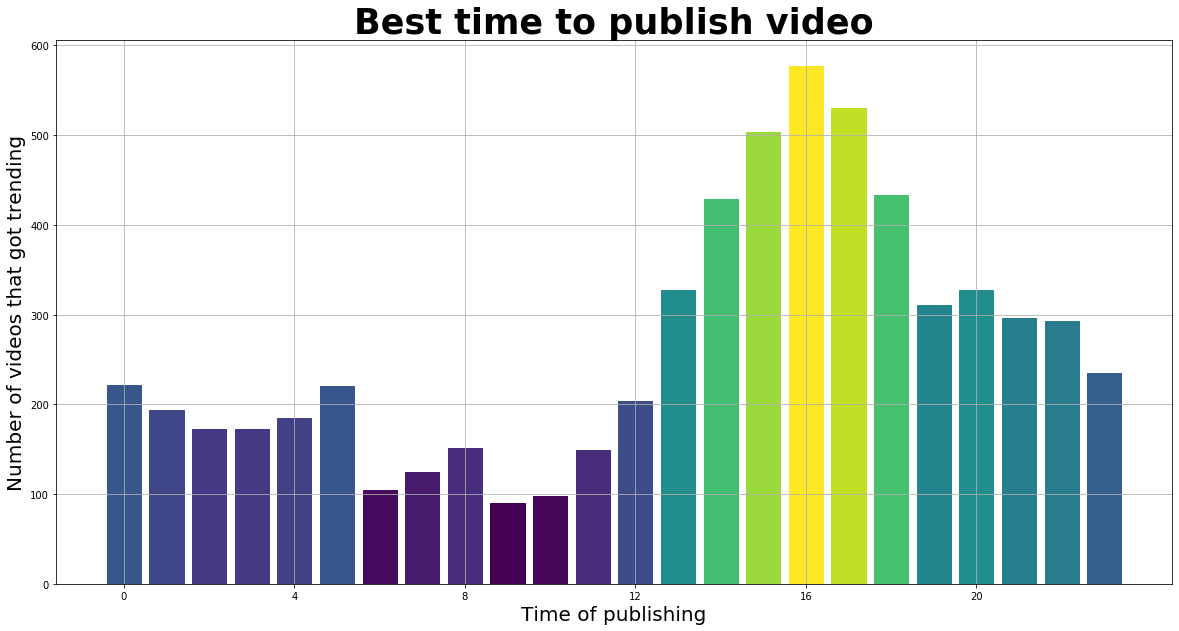

In [15]:
# Initialization of the list storing counters for subsequent publication hours
publish_h = [0] * 24

for index, row in us_videos_first.iterrows():
    publish_h[row["publish_hour"]] += 1
    
values = publish_h
ind = np.arange(len(values))


# Creating new plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.yaxis.grid()
ax.xaxis.grid()
bars = ax.bar(ind, values)

# Sampling of Colormap
for i, b in enumerate(bars):
    b.set_color(plt.cm.viridis((values[i] - min(values))/(max(values)- min(values))))
    
plt.ylabel('Number of videos that got trending', fontsize=20)
plt.xlabel('Time of publishing', fontsize=20)
plt.title('Best time to publish video', fontsize=35, fontweight='bold')
plt.xticks(np.arange(0, len(ind), len(ind)/6), [0, 4, 8, 12, 16, 20])

plt.show()

### 2.2. It got viral
<a id="it_got_viral"></a>

In [16]:
from IPython.display import HTML, display

# We choose the 10 most trending videos
selected_columns = ['title', 'channel_title', 'thumbnail_link', 'publish_date', 'category']

most_frequent = us_videos.groupby(selected_columns)['video_id'].agg(
    {"code_count": len}).sort_values(
    "code_count", ascending=False
).head(10).reset_index()

# Construction of HTML table with miniature photos assigned to the most popular movies
table_content = ''
max_title_length = 50

for date, row in most_frequent.T.iteritems():
    HTML_row = '<tr>'
    HTML_row += '<td><img src="' + str(row[2]) + '"style="width:100px;height:100px;"></td>'
    HTML_row += '<td>' + str(row[1]) + '</td>'
    HTML_row += '<td>' + str(row[0])  + '</td>'
    HTML_row += '<td>' + str(row[4]) + '</td>'
    HTML_row += '<td>' + str(row[3]) + '</td>'
    
    table_content += HTML_row + '</tr>'

display(HTML(
    '<table><tr><th>Photo</th><th>Channel Name</th><th style="width:250px;">Title</th><th>Category</th><th>Publish Date</th></tr>{}</table>'.format(table_content))
)

/media/kishonylab/KishonyStorage/galn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




Photo,Channel Name,Title,Category,Publish Date
,Lucas and Marcus,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Entertainment,2018-05-13
,Charlie Puth,Charlie Puth - BOY [Official Audio],Music,2018-05-11
,Rooster Teeth,Rooster Teeth Animated Adventures - Millie So Serious,Film & Animation,2018-05-14
,grav3yardgirl,Why I'm So Scared (being myself and crying too much),Howto & Style,2018-05-14
,SamSmithWorldVEVO,Sam Smith - Pray (Official Video) ft. Logic,Music,2018-05-09
,Unbox Therapy,"The ULTIMATE $30,000 Gaming PC Setup",Science & Technology,2018-05-13
,Complex,YoungBoy Never Broke Again Goes Sneaker Shopping With Complex,Entertainment,2018-05-14
,nigahiga,FORTNITE The Movie (Official Fake Trailer),Entertainment,2018-05-11
,Selena Gomez,Selena Gomez - Back To You (Lyric Video),Film & Animation,2018-05-10
,BostonDynamics,"Getting some air, Atlas?",Science & Technology,2018-05-10


### 2.3. Most influential creators
<a id="most_influential_creators"></a>

In [17]:
max_title_length = 30
number_of_creators = 25

top_creators = us_videos.groupby(['channel_title'])['channel_title'].agg(
    {"code_count": len}).sort_values(
    "code_count", ascending=False
).head(number_of_creators).reset_index()

trace1 = go.Bar(
    y = [(x if len(x) <= max_title_length else x[:max_title_length] + "...") for x in top_creators.channel_title.values][::-1],
    x = top_creators['code_count'].tolist()[::-1],
    name = "Top creators",
    orientation = 'h',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    ),
)

data = [trace1]

layout = go.Layout(
    title = 'Most influential creators',
    width=900,
    height=600,
    margin=go.Margin(
        l=180,
        r=50,
        b=80,
        t=80,
        pad=10
    ),
    paper_bgcolor='rgb(244, 238, 225)',
    plot_bgcolor='rgb(244, 238, 225)',
    yaxis = dict(
        anchor = 'x',
        rangemode='tozero',
        tickfont=dict(
            size=10
        ),
        ticklen=1
    ), 
    xaxis = dict(
        title= 'Number of times video made by creator got trending',
        anchor = 'x',
        rangemode='tozero'
    ), 
    legend=dict(x=0.6, y=0.07)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

/media/kishonylab/KishonyStorage/galn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




### 2.4. Variety of topics
<a id="variety_of_topics"></a>

In [18]:
max_title_length = 30
number_of_creators = 10

top_creators = us_videos.groupby(['category'])['category'].agg(
    {"code_count": len}).sort_values(
    "code_count", ascending=False
).head(number_of_creators).reset_index()

trace1 = go.Bar(
    y = [(x if len(x) <= max_title_length else x[:max_title_length] + "...") for x in top_creators.category.values][::-1],
    x = top_creators['code_count'].tolist()[::-1],
    name = "Top categories",
    orientation = 'h',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    ),
)

data = [trace1]

layout = go.Layout(
    title = 'Most popular categories',
    width=900,
    height=600,
    margin=go.Margin(
        l=180,
        r=50,
        b=80,
        t=80,
        pad=10
    ),
    paper_bgcolor='rgb(244, 238, 225)',
    plot_bgcolor='rgb(244, 238, 225)',
    yaxis = dict(
        anchor = 'x',
        rangemode='tozero',
        tickfont=dict(
            size=10
        ),
        ticklen=1
    ), 
    xaxis = dict(
        title= 'The number of times the video of a given category was trending',
        anchor = 'x',
        rangemode='tozero'
    ), 
    legend=dict(x=0.6, y=0.07)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

/media/kishonylab/KishonyStorage/galn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




### 2.5. Late bloomers
<a id="late_bloomers"></a>
This section dedicated to videos that waited the longest before they became trending. I also checked how many views they had when they hit the YouTube home page.

In [19]:
max_title_length = 20
number_of_late_bloomers = 20

late_bloomers = us_videos_first.sort_values(["time_to_trend"], ascending=False).head(number_of_late_bloomers)
late_bloomers_title = [(x if len(x) <= max_title_length else x[:max_title_length] + "...") for x in late_bloomers.title.values]
late_bloomers_days = late_bloomers.time_to_trend.values
late_bloomers_views = late_bloomers.views.values

trace1 = go.Bar(
    x = late_bloomers_title,
    y = late_bloomers_days,
    name='Number of days',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)
trace2 = go.Bar(
    x = late_bloomers_title,
    y = late_bloomers_views,
    name='total views',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    ),
    yaxis='y2'
)


data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title = 'Late bloomers',
    width=900,
    height=500,
    margin=go.Margin(
        l=75,
        r=75,
        b=120,
        t=80,
        pad=10
    ),
    paper_bgcolor='rgb(244, 238, 225)',
    plot_bgcolor='rgb(244, 238, 225)',
    yaxis = dict(
        title= 'Number of days until becoming trending',
        anchor = 'x',
        rangemode='tozero'
    ),   
    yaxis2=dict(
        title='Total number of views',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right',
        anchor = 'x',
        rangemode = 'tozero',
        dtick = 61000
    ),
    #legend=dict(x=-.1, y=1.2)
    legend=dict(x=0.1, y=0.05)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 2.6. No such thing as bad press, right?
<a id="no_such_thing_as_bad_press_right"></a>
This section dedicated to videos that has gained popularity on YT by being disliked.

In [20]:
max_title_length = 20
number_of_late_bloomers = 10

most_disliked = us_videos_first.sort_values(["dislikes"], ascending=False).head(number_of_late_bloomers)
most_disliked_title = [(x if len(x) <= max_title_length else x[:max_title_length] + "...") for x in late_bloomers.title.values]
most_disliked_l_number = most_disliked.likes.values
most_disliked_dl_number = most_disliked.dislikes.values
most_disliked_dl_percentage = most_disliked.dislike_percentage.values

trace1 = go.Bar(
    x = most_disliked_title,
    y = most_disliked_l_number,
    name='Number of likes',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)
trace2 = go.Bar(
    x = most_disliked_title,
    y = most_disliked_dl_number,
    name='Number of dislikes',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    )
)

trace3 = go.Scatter(
    x = most_disliked_title,
    y = most_disliked_dl_percentage,
    name='Dislike percentage',
    mode = 'markers',
    marker=dict(
        symbol="hexagon-dot",
        size=15
    ),
    yaxis='y2'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title = 'No such thing as bad press, right?',
    width=900,
    height=500,
    margin=go.Margin(
        l=75,
        r=75,
        b=120,
        t=80,
        pad=10
    ),
    paper_bgcolor='rgb(244, 238, 225)',
    plot_bgcolor='rgb(244, 238, 225)',
    yaxis = dict(
        title= 'Number of likes/dislikes',
        anchor = 'x',
        rangemode='tozero'
    ),   
    yaxis2=dict(
        title='Dislike percentage',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right',
        anchor = 'x',
        rangemode = 'tozero',
        dtick = 0.165
    ),
    legend=dict(x=0.75, y=1)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

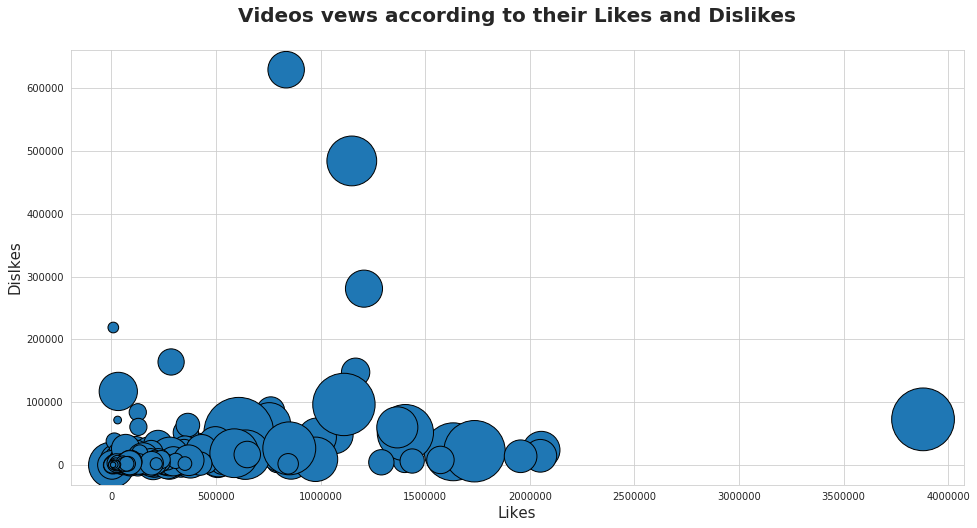

In [21]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
plt.title('Videos vews according to their Likes and Dislikes', fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Likes', fontsize=15)
plt.ylabel('Dislkes', fontsize=15)

likes = us_videos_first["likes"].values
dislikes = us_videos_first["dislikes"].values
views = us_videos_first["views"].values

plt.scatter(likes, dislikes, s = views/10000, edgecolors='black')
plt.show()

### 2.7. Likes vs dislikes distribution!
<a id="likes_vs_dislikes_distribution"></a>

In [22]:
hist_data = [us_videos_first["dislikes_log"].values, us_videos_first["likes_log"].values]

group_labels = ['Dislikes log distribution', 'Likes log distribution']
colors = ['#A6ACEC', '#63F5EF']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, colors=colors,
                         bin_size=0.5, show_rug=False)

# Add title
fig['layout'].update(title='Likes vs dislikes', legend=dict(x=0.65, y=0.8))

# Plot!
py.iplot(fig, filename='Hist and Curve')

In [23]:
us_videos_first.to_parquet('../input/USfirst.parq')

***
# My work

In [310]:
# vids without likes or dislikes are wierd 
us_videos_first = us_videos_first[(us_videos_first["likes"] > 0) & (us_videos_first["dislikes"] > 0)]

In [100]:
# NLP words source:
# title, tags("taga"|"tagb"), description

# herarcial sources:
# channel_title, category, tags

# boolean statistical columns
# existance tags\words, comments_disabled, ratings_disabled, video_error_or_removed

# also possible - ancestral reconstrion for continues veriables. these bring into play:
# views, likess, dislikes, comment_count

# implemented in R here: http://www.phytools.org/eqg/Exercise_5.2/
# BayesTraits has BayesContinuous also
# This looks very promissing:
# https://github.com/michaelgruenstaeudl/WARACS

In [101]:
# possible questions:

# which tags are in the same semantic felid?
# what tag is most correlated with view/comment/likes/(like/dislike ratio) etc.
# what tag's are assosiated with like/dislike ratio (or binirize the ratio)

## Workplan
* clean tag and description text, and use tokenize pipe
* create sparse "token over vid" matrix - (include - categories columns !!!)
* herarchial clustering based on sparse onehot matrix (cat, tag, channel)
* ancestral reconstruction of traits: useing MaxParsimony for sparse tokens
* Bonus: ancestral reconstruction of cont traits - using BayesContinuous of the 5 continues columns

In [249]:
# TODO clean tags/cat/desc here

In [108]:
us_videos_first['list_tags'] = us_videos_first['tags'].apply(lambda x: x.replace('\"','').split('|'))

In [130]:
tag_tokens = (set(np.concatenate([x.split(' ') for x in np.concatenate(us_videos_first['list_tags'].values)])))
tag_dict = dict(zip(tag_tokens, range(len(tag_tokens))))

In [216]:
# tag diversity
import tqdm

diverse_dict = dict()
for i, row in tqdm.tqdm_notebook(us_videos_first.iterrows(), total=len(us_videos_first)):
    for k in row['list_tags']:
        for word in k.split(' '):
            if word == '': continue
            diverse_dict[word] = diverse_dict.get(word, [])+[row['channel_title']]
            # diverse_dict.update({word:diverse_dict.get(word, [])+[row['channel_title']]})
for k in diverse_dict:
    diverse_dict[k] = len(set(diverse_dict[k]))

11106.0

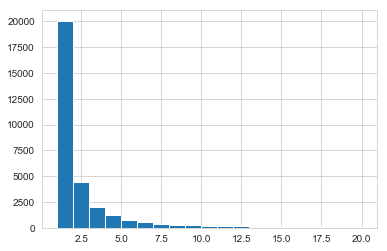

In [244]:
# there are 10k/30k tags with at least 2 channels using them - we have "channel title for the rest".
tag_diverse_series = pd.Series(diverse_dict)
plt.hist(tag_diverse_series, bins=range(1, 21, 1))[0][1:].sum()

In [246]:
usable_tags = tag_diverse_series[tag_diverse_series>1].index.tolist()
usable_tags = dict(zip(usable_tags, range(len(usable_tags))))

In [352]:
# TODO use gensim for sparse row tags

In [326]:
sparse_channels = sp.csr_matrix(pd.get_dummies(us_videos_first['channel_title'], sparse=True).values)
sparse_channels_rep = sparse_channels[:, np.argwhere(sparse_channels.sum(axis=0) > 1)[:, 1]]

In [330]:
sparse_cat = sp.csr_matrix(pd.get_dummies(us_videos_first['category_id']).values)

In [336]:
quality_map = sp.hstack([sparse_cat, sparse_channels_rep]) # todo add tokens...

In [350]:
from sklearn.metrics import pairwise
dist_mat = pairwise.cosine_distances(quality_map)

array([[0. , 1. , 1. , ..., 1. , 1. , 1. ],
       [1. , 0. , 1. , ..., 0.5, 1. , 0.5],
       [1. , 1. , 0. , ..., 1. , 1. , 1. ],
       ...,
       [1. , 0.5, 1. , ..., 0. , 1. , 0.5],
       [1. , 1. , 1. , ..., 1. , 0. , 1. ],
       [1. , 0.5, 1. , ..., 0.5, 1. , 0. ]])

In [353]:
# TODO remind yerself how to convert to tree ktnxby